# South African Heart Disease

In [1]:
import cvxpy as cp
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv("../data/South African Heart Disease.txt")
df['famhist'] = pd.get_dummies(df['famhist'])['Present']
target = ['chd']
features = ['sbp', 'tobacco', 'ldl', 'famhist', 'obesity', 'alcohol', 'age']
X, y = df[features].values, df[target].values
y_flat = np.squeeze(y)
df[features + target].head()

,sbp,tobacco,ldl,famhist,obesity,alcohol,age,chd
0,160,12.00,5.73,1,25.30,97.20,52,1
1,144,0.01,4.41,0,28.87,2.06,63,1
2,118,0.08,3.48,1,29.14,3.81,46,0
3,170,7.50,6.41,1,31.99,24.26,58,1
4,134,13.60,3.50,1,25.99,57.34,49,1


## Baseline Accuracy Score

In [3]:
print(f'Baseline test accuracy score: {accuracy_score(y_flat, np.zeros(y_flat.shape[0])):0.3f}')

Baseline test accuracy score: 0.654


## Linear Regression

In [4]:
reg = LinearRegression().fit(X, y)
for feature, coef in list(zip(features, reg.coef_[0])):
    print(f'{feature:>14} {coef:>10.4f}')
y_hat = (np.squeeze(reg.predict(X))>0.5)+0
print('-------------------------')
print(f'accuracy score {accuracy_score(y_flat, y_hat):>10.4f}')

           sbp     0.0012
       tobacco     0.0170
           ldl     0.0359
       famhist     0.1806
       obesity    -0.0074
       alcohol    -0.0001
           age     0.0067
-------------------------
accuracy score     0.7359


## Linear Constrained Regression with CVXPY

In [5]:
coef_ = cp.Variable(len(features))
intercept_ = cp.Variable(1)
loss = cp.sum_squares(y - intercept_ - X@coef_)
constraints = [0 <= coef_]
prob = cp.Problem(cp.Minimize(loss), constraints)
prob.solve()

ValueError: Cannot broadcast dimensions  (462, 1) (462,)

In [6]:
coef_ = np.array(coef_.value)
for feature, coef in list(zip(features, np.squeeze(coef_))):
    print(f'{feature:>14} {coef:>10.4f}')
y_hat = (np.squeeze(intercept_.value + X@coef_)>0.5)+0
print('-------------------------')
print(f'accuracy score {accuracy_score(y_flat, y_hat):>10.4f}')

TypeError: zip argument #2 must support iteration

In [15]:
from numpy.random import multivariate_normal
from matplotlib import pyplot as plt

In [122]:
mean = (1, 2)
cov = [[1, 0], [0, 1]]
X = np.random.multivariate_normal(mean, cov, 700).T

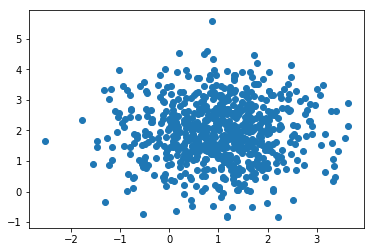

In [123]:
plt.scatter(X[0, :], X[1, :])

In [124]:
X.shape

(2, 700)

In [159]:
p = 5
m, n = X.shape

idxs = np.random.choice(n, p, replace=False)
Z = X[:, idxs]
B = np.zeros(shape=(n, p))
for i, idx in enumerate(idxs):
    B[idx, i] = 1

In [160]:
for i in range(100):
    A = cp.Variable((p, n))
    objective = cp.Minimize(cp.norm(X - Z@A, 'fro'))
    constraint = [0 <= A, A <= 1, cp.sum(A, axis=0) == 1]
    prob = cp.Problem(objective, constraint)
    result = prob.solve()
    A_ = A.value
    
    R = X - Z@A_
    for j in range(p):
        aj = A_[j].reshape((1, n))
        aj_norm = aj@aj.T
        zj = Z[:, j].reshape((m, 1))

        b = cp.Variable((n, 1))
        
        objective = cp.Minimize(cp.norm(R@aj.T/aj_norm + zj - X@b))
        constraint = [0 <= b, b <= 1, cp.sum(b) == 1]
        
        prob = cp.Problem(objective, constraint)
        result = prob.solve()
        
        R = R + (zj - X@b.value)@aj
        Z[:, j] = (X@b.value)[:,0]

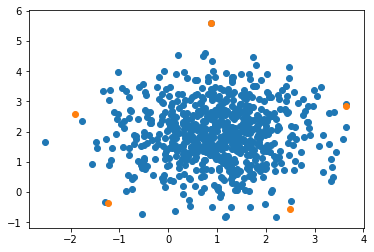

In [161]:
plt.scatter(X[0, :], X[1, :])
plt.scatter(Z[0, :], Z[1, :])